In [20]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 

import torch 
from torch import nn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from typing import Optional,Callable

In [3]:
class Data:

  def __init__(self,X1:torch.Tensor,y :torch.Tensor,X2:Optional[torch.Tensor]= None,n_samples = 30):
    
    
    self.X1 = torch.tensor(X1).flatten()
    self.y  = torch.tensor(y).flatten()
    self.X2 = self.X2 = torch.tensor(X2) if X2 is not None else None
    self.n_samples = n_samples



#----------------------------------------------------------------------------------------------------------------PLOT DATA
  def plot_data(self):
#---------------------------ONE FEATURES--------------------
    if (self.X2 is None):
      plot = go.Scatter(
        x = self.X1,
        y = self.y,
        mode = 'markers',
      )

      layout = go.Layout(
              title='Single Feature Regression Plot',
              xaxis=dict(title='X1'),
              yaxis=dict(title='Y'),
              hovermode='closest')

  #-----------TWO FEATURES--------
    if (self.X2 is not None):
      plot = go.Scatter3d(
        x = self.X1,
        y = self.X2,
        z = self.y,
        mode = 'markers'
      )

      layout = go.Layout(
              title='Two Features Regression Plot',
              scene=dict(
                  xaxis_title='X1',
                  yaxis_title='X2',
                  zaxis_title='Y'
              ),
              hovermode='closest')

    figure = go.Figure(data=[plot],layout=layout)
    return figure.show()
  

#----------------------------------------------------------------------------------------------------------------PLOT LOSS LANDSCAPE
  def landscape(self,
                bias = False,
                cost_fn = nn.MSELoss(),
                secret_w1 = 5,
                span = 10):

    secret_w1 = torch.tensor(secret_w1,dtype=torch.long)
    #-------------------------------------ONE FEATURES-----------------------------------
    if (self.X2 is None) and (bias is False):
      w1_range = torch.linspace(secret_w1-10,secret_w1+10,self.n_samples)
      landscape = go.Scatter(
        x = w1_range,
        y = [cost_fn((self.X1*w),self.y).item() for w in w1_range],
        mode = 'lines'
      )
    
    #-------------------------------------TWO FEATURES-----------------------------------
    if (self.X2 is not None) and (bias is False):
  
      w1_m,w2_m = torch.meshgrid(torch.linspace(-span,span,self.n_samples ),torch.linspace(-span,span,self.n_samples ),indexing='ij')
      w1_f,w2_f = w1_m.flatten() , w2_m.flatten()

      COST = []
      for w1,w2 in zip(w1_f,w2_f):
        pred = (w1*self.X1) + (w2*self.X2)
        cost = cost_fn(pred,self.y)
        COST.append(cost.item())
      COST = torch.tensor(COST).view(self.n_samples ,self.n_samples )

      landscape = go.Surface(
        x = w1_m,
        y = w2_m,
        z = COST,
      )

    # -------------------------------------ONE FEATURE AND BIAS-----------------------------------
    if (self.X2 is  None) and (bias is True):


      w1_m,b_m = torch.meshgrid(torch.linspace(-span,span,self.n_samples ),torch.linspace(-span,span,self.n_samples ),indexing='ij')
      w1_f,b_f = w1_m.flatten() , b_m.flatten()

      COST = []
      for w1,b in zip(w1_f,b_f):
        pred = (w1*self.X1) + b
        cost = cost_fn(pred,self.y)
        COST.append(cost.item())
      COST = torch.tensor(COST).view(self.n_samples ,self.n_samples )

      landscape = go.Surface(
        x = w1_m,
        y = b_m,
        z = COST
      )


    figure = go.Figure(data=[landscape])
    return figure.show()

In [25]:
X,y,coef = datasets.make_regression(n_features=1,n_samples=20,coef=True,noise=2,bias=20)


stand_scale = StandardScaler()
X = stand_scale.fit_transform(X)
y = stand_scale.fit_transform(y.reshape(-1,1))

print(X.shape)
print(y.shape)
print(coef)


(20, 1)
(20, 1)
13.080915507017732


In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [29]:
print(lin_reg.coef_)

[[0.9911013]]


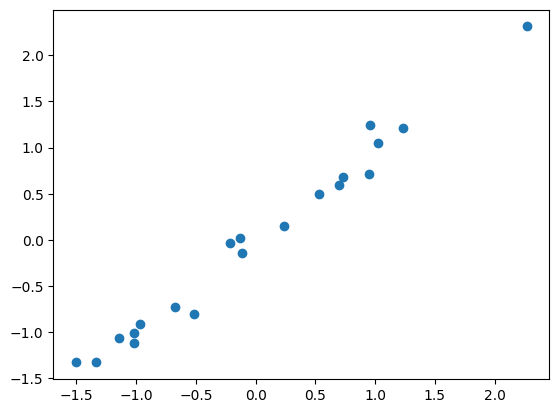

In [28]:
plt.scatter(X,y)

In [17]:
coef_tensor = torch.tensor(coef,dtype=torch.long)
coef_tensor

tensor(69)

In [6]:
first_set = Data(X[:,0],y,X[:,1])

In [7]:
first_set.plot_data()

In [8]:
first_set.landscape(bias=False,cost_fn=nn.MSELoss())